In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pingouin as pg

sns.set(style='white')

### Задание 1. A/B–тестирование

*Условие*. Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

*Входные данные*. В качестве входных данных вы имеете 4 csv-файла:

- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа);
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных;
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента;
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.

*Вопросы*. Предлагаем вам ответить на следующие вопросы:

- На какие метрики вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

In [2]:
groups = pd.read_csv('groups.csv', sep=';')
group_add = pd.read_csv('group_add.csv')
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';')

Проведем **разведочный** анализ данных.

In [3]:
# Изучим содержимое датафреймов
groups.head(10)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
5,1803,B
6,1805,B
7,2067,A
8,2078,A
9,2080,B


In [4]:
print(f'Количество строк в датафрейме groups = {groups.shape[0]}')
print(f'Количество уникальных пользователей в датафрейме groups = {groups.id.nunique()}')

Количество строк в датафрейме groups = 74484
Количество уникальных пользователей в датафрейме groups = 74484


Каждая строка в датафрейме groups соответствует уникальному пользователю образовательной платформы.

In [5]:
quantity = groups.groupby('grp').id.count()
print(f'Количество пользователей в контрольной группе(А) равно {quantity.iloc[0]} \
({round((quantity.iloc[0] / groups.shape[0] * 100), 1)}% от общего количества)')
print(f'Количество пользователей в целевой группе(B) равно {quantity.iloc[1]} \
({round((quantity.iloc[1] / groups.shape[0] * 100), 1)}% от общего количества)')

Количество пользователей в контрольной группе(А) равно 14671 (19.7% от общего количества)
Количество пользователей в целевой группе(B) равно 59813 (80.3% от общего количества)


Заметим, что количество пользователей в целевой группе (B) сильно больше, чем в контрольной (А). Репрезентативность выборок мы не можем оценить иначе, так как нет для этого данных. Для получения достоверных результатов эксперимента следовало бы пересмотреть систему сплитования, чтобы размер выборок был сопоставимым.

In [6]:
# Изучим файл, который нам прислали спустя 2 дня после начала эксперимента
group_add.head(10)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
5,5699132,B
6,5699712,B
7,5700613,B
8,5700771,B
9,5701056,B


In [7]:
print(f'Количество строк в датафрейме group_add = {group_add.shape[0]}')
print(f'Количество уникальных пользователей в датафрейме group_add = {group_add.id.nunique()}')

Количество строк в датафрейме group_add = 92
Количество уникальных пользователей в датафрейме group_add = 92


In [8]:
group_add.groupby('grp').id.count()

grp
A    22
B    70
Name: id, dtype: int64

Заметим, что id пользователей в датафреймах groups и group_add по умолчанию отсортированы в порядке возрастания.

In [9]:
groups.tail()

,id,grp
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B
74483,5694419,B


In [10]:
groups.id.max()

5694419

In [11]:
group_add.id.min()

5694584

Датафрейм groups заканчивается на id = 5694419. Датафрейм group_add начинается с id = 5694584. Складывается впечатление, что *файл group_add является продолжением groups*.

В задании 3 данного проекта требуется реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и пересчитывать метрики. Поэтому *A/B-тест будем проводить без учета этого дополнительного файла*, как если бы у нас его не было. Метрики пересчитаем позже.

Посмотрим, сколько пользователей зашли на платформу в дни проведения эксперимента.

In [12]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
print(f'Количество строк в датафрейме active_studs = {active_studs.shape[0]}')
print(f'Количество уникальных пользователей в датафрейме active_studs = {active_studs.student_id.nunique()}')

Количество строк в датафрейме active_studs = 8341
Количество уникальных пользователей в датафрейме active_studs = 8341


В файле active_studs хранятся данные об уникальных пользователях в дни проведения эксперимента (дубликатов нет).\
Соединим информацию об активных студентах с датафреймом groups.

In [14]:
groups = groups.rename(columns={'id': 'student_id'})

In [15]:
groups_active = groups.merge(active_studs, on='student_id', how='inner')

In [16]:
groups_active.head()

,student_id,grp
0,1627,A
1,2085,B
2,2215,B
3,3391,A
4,3401,B


In [17]:
groups_active.shape

(8328, 2)

Посмотрим, какие 13 пользователей не попали в объединенный датафрейм groups_active.

In [18]:
lost_students = active_studs.merge(groups_active, on='student_id', how='left')
lost_students = lost_students.loc[lost_students['grp'].isnull()]
lost_students

,student_id,grp
1,5723133,NaN
111,5951797,NaN
632,5730382,NaN
2662,5739944,NaN
3830,5945085,NaN
4900,5700613,NaN
5254,5729371,NaN
5746,5777081,NaN
7413,5740903,NaN
7505,5760471,NaN


In [19]:
group_add.id.apply(lambda x: 1 if x in list(lost_students.student_id) else 0).sum()

13

Эти студенты принадлежат к датафрейму group_add. Они не будут участвовать в эксперименте сейчас.

In [20]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [21]:
print(f'Количество строк в датафрейме checks = {checks.shape[0]}')
print(f'Количество уникальных пользователей в датафрейме checks = {checks.student_id.nunique()}')

Количество строк в датафрейме checks = 541
Количество уникальных пользователей в датафрейме checks = 541


In [22]:
checks.rev.value_counts()

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
2910.0000     4
2890.0000     4
1980.0000     4
2099.0000     3
489.0000      3
1160.0000     3
1180.0000     2
2220.0000     2
2820.0000     2
597.0000      1
1388.0000     1
3260.0000     1
880.0000      1
3040.0000     1
796.0000      1
1968.0000     1
1339.0000     1
4650.0000     1
2900.0000     1
630.0000      1
1830.0000     1
1039.0000     1
1050.0000     1
1729.0000     1
2190.0000     1
Name: rev, dtype: int64

Мы наблюдаем множество различных вариантов чеков. Скорее всего, данные по платящим пользователям в исходном файле checks уже агрегированы, и столбец 'rev' отражает сумму платежей по пользователям. Возможно, пользователи платили за отдельные горошины или за отдельные уроки, или за курсы по дисциплинам несколько раз. 

In [23]:
group_add.id.apply(lambda x: 1 if x in list(checks.student_id) else 0).sum()

1

In [24]:
groups.student_id.apply(lambda x: 1 if x in list(checks.student_id) else 0).sum()

540

In [25]:
active_studs.student_id.apply(lambda x: 1 if x in list(checks.student_id) else 0).sum()

392

Проводили оплату на платформе в дни эксперимента 540 студентов из датафрейма groups и только 1 студент из group_add.
При этом 149 студентов (541 - 392) производили оплату на платформе, но не были активны в дни эксперимента.\
В теории, платящими и неактивными могут быть пользователи, у которых произошло автоматическое продление подписки в дни проведения эксперимента.

Посмотрим на платежи этих 149 *платящих, но неактивных студентов*

In [26]:
paying_inactive = checks.merge(active_studs, on='student_id', how='left', indicator=True)
paying_inactive.head()

,student_id,rev,_merge
0,1627,990.0,both
1,3185,690.0,left_only
2,25973,690.0,left_only
3,26280,690.0,left_only
4,100300,990.0,both


In [27]:
paying_inactive = paying_inactive.loc[paying_inactive['_merge'] == 'left_only']
paying_inactive = paying_inactive.drop('_merge', axis=1)
paying_inactive.head()

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0


In [28]:
paying_inactive.rev.describe()

count     149.000000
mean      708.268457
std       378.699192
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      1980.000000
Name: rev, dtype: float64

In [29]:
paying_inactive.rev.value_counts()

690.0000     61
290.0000     24
990.0000     19
199.0000     14
1140.0000    14
1900.0000     4
580.0000      4
840.0000      3
398.0000      2
1900.0001     1
1180.0000     1
1980.0000     1
630.0000      1
Name: rev, dtype: int64

In [30]:
paying_inactive.rev.nunique()

13

У "платящих и неактивных" пользователей, как мы видим, 13 различных вариантов сумм платежей в дни эксперимента. Это не похоже на ситуацию автоматического продления подписки у неактивных пользователей. Некоторые из этих студентов совершили, вероятно, даже несколько платежей. Возможно, произошла ошибка в сборе данных, и активность этих студентов не была учтена. **Необходимо разобраться, в чем причина появления в данных таких "платящих и неактивных студентов"**. Мы не будем включать этих студентов в A/B-тест. **Будем учитывать только студентов из файла active_studs**.

**Соберем итоговый датафрейм** для анализа результатов эксперимента (пока что *без учета group_add*). Нам важны *только активные студенты*, так как именно они могли видеть (или - для контрольной группы - не видеть) новую механику оплаты.

In [31]:
control_test = groups_active.merge(checks, on='student_id', how='left')
control_test.head()

,student_id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN


In [32]:
print(f'Количество пользователей в контрольной группе(А) равно {control_test.grp.value_counts().loc["A"]} \
({round((control_test.grp.value_counts().loc["A"] / control_test.shape[0] * 100), 1)}% от общего количества)')
print(f'Количество пользователей в целевой группе(B) равно {control_test.grp.value_counts().loc["B"]} \
({round((control_test.grp.value_counts().loc["B"] / control_test.shape[0] * 100), 1)}% от общего количества)')

Количество пользователей в контрольной группе(А) равно 1535 (18.4% от общего количества)
Количество пользователей в целевой группе(B) равно 6793 (81.6% от общего количества)


In [33]:
# Для удобства создадим отдельные датафреймы для контрольной и тестовой групп
control = control_test.query('grp == "A"')
test = control_test.query('grp == "B"')

Посмотрим на распределение доходов в контрольной и целевой группах.

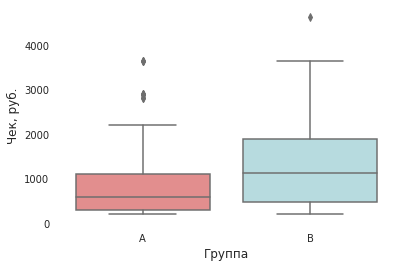

In [34]:
sns.boxplot(data=control_test,
            x='grp',
            y='rev',
            palette=['lightcoral', 'powderblue'])
plt.ylabel('Чек, руб.', size=12)
plt.xlabel('Группа', size=12)
plt.yticks(size=10)
plt.xticks(size=10)
sns.despine(left=True, bottom=True)
plt.show()

In [35]:
print(f'Минимальная сумма чека для контрольной группы составила {int(control.rev.min())} руб., \
а максимальная - {int(control.rev.max())} руб.')
print(f'Медианный чек для контрольной группы равен {int(control.rev.median())} руб.')

Минимальная сумма чека для контрольной группы составила 199 руб., а максимальная - 3660 руб.
Медианный чек для контрольной группы равен 585 руб.


In [36]:
print(f'Минимальная сумма чека для целевой группы составила {int(test.rev.min())} руб., \
а максимальная - {int(test.rev.max())} руб.')
print(f'Медианный чек для целевой группы равен {int(test.rev.median())} руб.')

Минимальная сумма чека для целевой группы составила 199 руб., а максимальная - 4650 руб.
Медианный чек для целевой группы равен 1140 руб.


*Медианный чек на платящего пользователя в целевой группе выше, чем в контрольной*. В обеих группах зафиксированы аномально высокие значения.

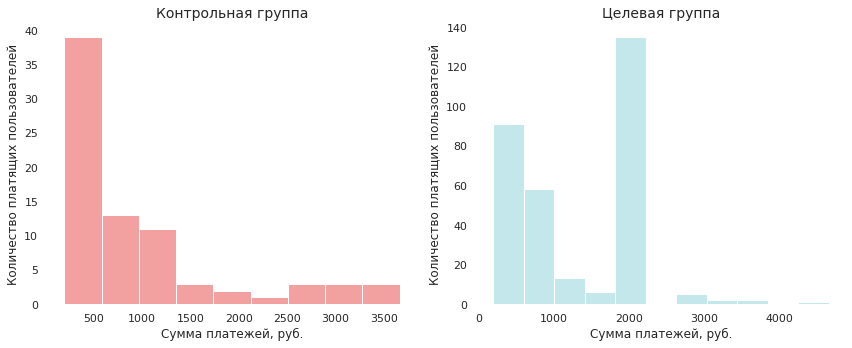

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=control,
             x='rev',
             ax=axes[0],
             color='lightcoral')
axes[0].set_title('Контрольная группа', size=14)
axes[0].set_xlabel('Сумма платежей, руб.')
axes[0].set_ylabel('Количество платящих пользователей')

sns.histplot(data=test,
             x='rev',
             ax=axes[1],
             color='powderblue')
axes[1].set_title('Целевая группа', size=14)
axes[1].set_xlabel('Сумма платежей, руб.')
axes[1].set_ylabel('Количество платящих пользователей')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Визуально распределения пользователей контрольной и целевой групп по сумме платежей сильно отличаются от нормального. Распределения имеют правостороннюю асимметрию и содержат выбросы с высокой суммой платежей.

Проверим данные на нормальность с помощью теста Д'Агостино-Пирсона.

In [38]:
pg.normality(data=control_test, dv='rev', group='grp', method='normaltest')

,W,pval,normal
A,30.37842,2.531687e-07,False
B,7.02227,2.986301e-02,False


Тест Д'Агостино-Пирсона подтвердил, что *распределения в выборках отличаются от нормального*.

**Выберем метрики и сформулируем гипотезу.**

По условию кейса необходимо проверить успешность эксперимента по внедрению новой механики оплаты услуг на сайте. Нам точно не известно, какую проблему пользователей сайта мы хотим решить. Можно предположить, что новая механика оплаты избавит пользователей от ручного ввода реквизитов карты, занимающего много времени, и *студенты перестанут стопориться на оплате уроков/курсов*. Для того чтобы конкретизировать проблему в гипотезе, которую мы будем проверять, и выбрать интерпретируемые метрики, будем придерживаться этого предположения.\
Успех от эксперимента по введению новой механики оплаты наиболее ярко будут отражать метрики *конверсия в оплату (CR)*, *средний доход на пользователя (ARPU)* и *средний доход на платящего пользователя (ARPPU)*. В расчет метрик будем включать только тех пользователей, которые заходили на сайт и проходили уроки в дни эксперимента. Все эти метрики взаимосвязаны (ARPU = CR * ARPPU), они чувствительны к результатам эксперимента и интерпретируемы.

Сформулируем следующую гипотезу:\
**Если внедрим новую механику оплаты, то пользователи сайта образовательной платформы перестанут стопориться на оплате услуг, вследствие чего CR, ARPU и ARPPU статистически значимо увеличатся**.

Для проверки гипотезы относительно конверсии в оплату используем **критерий Хи-квадрат**, так как мы анализируем количество успешных событий (оплата) относительно общего числа активных пользователей. Для этого необходимо завести альтернативную переменную: 'paying' - пользователь конвертировался в платящего, 'not paying' - не конвертировался.

In [39]:
control_test_copy = control_test.copy()

In [40]:
control_test_copy['rev'] = control_test_copy['rev'].fillna(0)

In [41]:
control_test_copy['conversion'] = control_test_copy.rev.apply(lambda x: 'not paying' if x == 0 else 'paying')

In [42]:
control_test_copy.head()

,student_id,grp,rev,conversion
0,1627,A,990.0,paying
1,2085,B,0.0,not paying
2,2215,B,0.0,not paying
3,3391,A,0.0,not paying
4,3401,B,0.0,not paying


In [43]:
df_crosstab = pd.crosstab(index=control_test_copy.grp, columns=control_test_copy.conversion)
df_crosstab

conversion,not paying,paying
grp,,
A,1457,78
B,6480,313


In [44]:
print(f'Конверсия в оплату для контрольной группы (A) cоставила \
{round((df_crosstab.iloc[0, 1] / control.shape[0] * 100), 1)}%')
print(f'Конверсия в оплату для целевой группы (B) cоставила \
{round((df_crosstab.iloc[1, 1] / test.shape[0] * 100), 1)}%')

Конверсия в оплату для контрольной группы (A) cоставила 5.1%
Конверсия в оплату для целевой группы (B) cоставила 4.6%


**H0**: между контрольной и целевой группами различий в CR нет\
**H1**: между контрольной и целевой группами различия в CR есть

In [45]:
statistic, pvalue, dof, expected_freq = st.chi2_contingency(df_crosstab, correction=False)
# Количество наблюдений в каждой ячейке составляет более 10 -> поправку Йетса делать не нужно

In [46]:
pvalue

0.4280822964525912

Т.к. p-value > 0.05, у нас **нет оснований отвергнуть нулевую гипотезу**, и разница в CR между группами вполне может быть обусловлена случайностью.

Таким образом, **значимых различий между конверсией в оплату пользователей контрольной и целевой групп не обнаружено**. CR в тестовой группе (4.6%) немного ниже, чем в контрольной (5.1%).

Посчитаем метрики **ARPU** и **ARPPU** для наших выборок.

In [47]:
control_test_copy_A = control_test_copy.query('grp == "A"')
control_test_copy_B = control_test_copy.query('grp == "B"')

In [48]:
print(f'ARPU для контрольной группы составил {round((control_test_copy_A.rev.mean()), 2)} руб.')
print(f'ARPU для целевой группы составил {round((control_test_copy_B.rev.mean()), 2)} руб.')

ARPU для контрольной группы составил 47.44 руб.
ARPU для целевой группы составил 57.86 руб.


In [49]:
print(f'ARPPU для контрольной группы составил {round((control.rev.mean()), 2)} руб.')
print(f'ARPPU для целевой группы составил {round((test.rev.mean()), 2)} руб.')

ARPPU для контрольной группы составил 933.59 руб.
ARPPU для целевой группы составил 1255.83 руб.


In [50]:
# Занесем значения метрик в таблицу
metrics = pd.DataFrame([[round((control_test_copy_A.rev.mean()), 2), round((control.rev.mean()), 2)],
                       [round((control_test_copy_B.rev.mean()), 2), round((test.rev.mean()), 2)]],
                       columns=['ARPU', 'ARPPU'], index=['A', 'B'])

In [51]:
metrics

,ARPU,ARPPU
A,47.44,933.59
B,57.86,1255.83


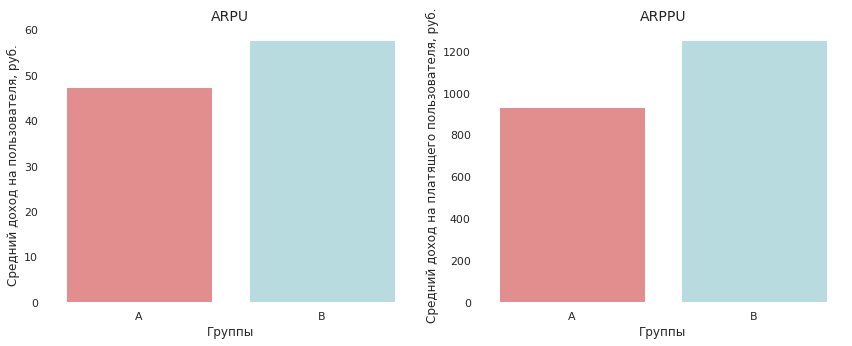

In [52]:
# Визуализируем наши расчеты
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=metrics,
            x=metrics.index,
            y='ARPU',
            ax=axes[0],
            palette=['lightcoral', 'powderblue'])
axes[0].set_title('ARPU', size=14)
axes[0].set_xlabel('Группы')
axes[0].set_ylabel('Средний доход на пользователя, руб.')

sns.barplot(data=metrics,
            x=metrics.index,
            y='ARPPU',
            ax=axes[1],
            palette=['lightcoral', 'powderblue'])
axes[1].set_title('ARPPU', size=14)
axes[1].set_xlabel('Группы')
axes[1].set_ylabel('Средний доход на платящего пользователя, руб.')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Отмечаем, что *метрики ARPU и ARPPU выше в целевой группе*. Разница особенно заметна в значениях ARPPU.

Как мы выяснили ранее, распределения в выборках по сумме платежей отличаются от нормального. В этих данных были пустые значения для случаев, когда пользователи не совершали оплату в дни эксперимента. Среднее, рассчитанное по этим данным, есть не что иное, как ARPPU, т.к. каждая строка данных соответствует уникальному пользователю. Использовать t-тест для сравнения средних значений (ARPPU) на данных в исходном виде мы не можем. Попробуем использовать *логарифмическую трансформацию*. Однако мы можем провести тест на логарифмах данных только по метрике ARPPU, т.к. данные для расчета ARPU будут включать нули (нельзя использовать логарифм).

In [53]:
control_log = control.copy()
control_log['rev'] = np.log(control_log['rev'])

In [54]:
test_log = test.copy()
test_log['rev'] = np.log(test_log['rev'])

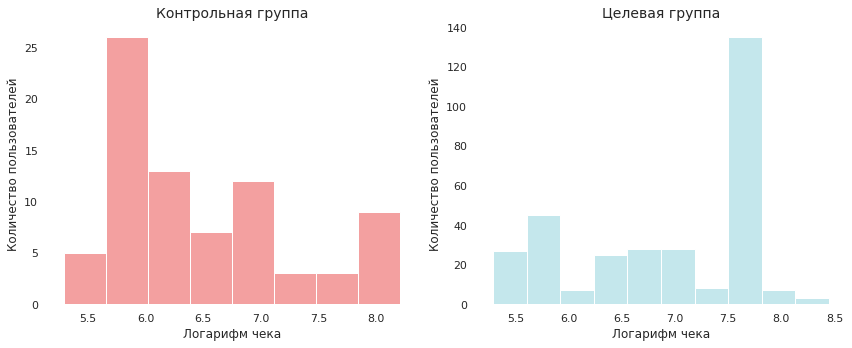

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=control_log,
             x='rev',
             ax=axes[0],
             color='lightcoral')
axes[0].set_title('Контрольная группа', size=14)
axes[0].set_xlabel('Логарифм чека')
axes[0].set_ylabel('Количество пользователей')

sns.histplot(data=test_log,
             x='rev',
             ax=axes[1],
             color='powderblue')
axes[1].set_title('Целевая группа', size=14)
axes[1].set_xlabel('Логарифм чека')
axes[1].set_ylabel('Количество пользователей')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Распределения после логарифмической трансформации данных все еще визуально не соответствуют нормальному. Проверим на нормальность с помощью теста Д'Агостино-Пирсона.

In [56]:
print(f'Для контрольной группы: {st.normaltest(control_log.rev.dropna())}')
print(f'Для целевой группы: {st.normaltest(test_log.rev.dropna())}')

Для контрольной группы: NormaltestResult(statistic=7.9915399191892345, pvalue=0.018393278875655582)
Для целевой группы: NormaltestResult(statistic=86.64991674044852, pvalue=1.5283036528109365e-19)


Тест на нормальность показал, что *после логарифмирования распределения все еще не соответствуют нормальному*.\
Проверим еще одно условие проведения t-теста: равенство дисперсий. Используем *тест Левена*. Проверяем гипотезу **H0**: дисперсии не различаются.

In [57]:
st.levene(control.rev.dropna(), test.rev.dropna())

LeveneResult(statistic=3.0558643506726035, pvalue=0.08123509393501775)

Нет оснований отвергнуть нулевую гипотезу => *дисперсии в двух выборках не различаются*.

In [58]:
st.levene(control_log.rev.dropna(), test_log.rev.dropna())

LeveneResult(statistic=0.10794168834088307, pvalue=0.7426765607631863)

После логарифмирования результаты теста также свидетельствуют о *равенстве дисперсий*.

Очевидно, что распределения всех пользователей, включая платящих и неплатящих, по сумме чека в контрольной и тестовой группах будут отличаться от нормального еще сильнее, т.к. данные состоят преимущественно из нулей. Посмотрим на эти распределения.

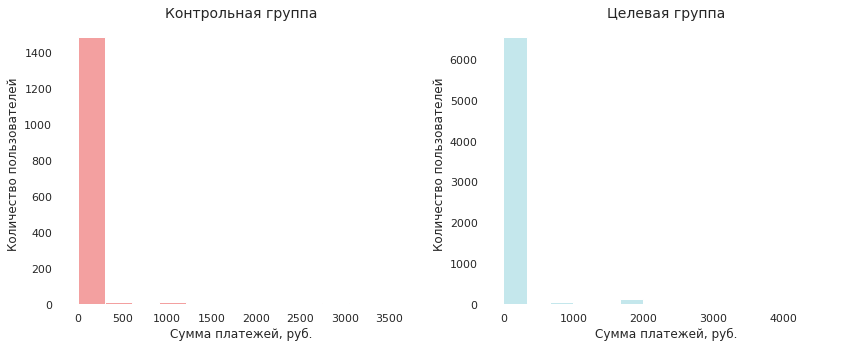

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=control_test_copy_A,
             x='rev',
             ax=axes[0],
             color='lightcoral')
axes[0].set_title('Контрольная группа', size=14)
axes[0].set_xlabel('Сумма платежей, руб.')
axes[0].set_ylabel('Количество пользователей')

sns.histplot(data=control_test_copy_B,
             x='rev',
             ax=axes[1],
             color='powderblue')
axes[1].set_title('Целевая группа', size=14)
axes[1].set_xlabel('Сумма платежей, руб.')
axes[1].set_ylabel('Количество пользователей')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [60]:
pg.normality(data=control_test_copy, dv='rev', group='grp', method='normaltest')

,W,pval,normal
A,2235.003893,0.0,False
B,7799.583992,0.0,False


Т.к. данные не соответствуют нормальному распределению, *мы не можем провести t-тест Стьюдента* (он может дать некорректные результаты). Используем **метод бутстрапа (bootstrap)**.

**H0**: Разница между выборками случайна (разность средних = 0).

In [61]:
# Рассчитаем доверительный интервал разницы ARPU для двух выборок
mean_diff_ARPU = []

for i in range(10000):
    sample_data_control_ARPU = control_test_copy_A.rev.sample(frac=1, replace=True)
    sample_mean_control_ARPU = sample_data_control_ARPU.mean()

    sample_data_test_ARPU = control_test_copy_B.rev.sample(frac=1, replace=True)
    sample_mean_test_ARPU = sample_data_test_ARPU.mean()

    sample_mean_diff_ARPU = sample_mean_control_ARPU - sample_mean_test_ARPU
    mean_diff_ARPU.append(sample_mean_diff_ARPU)

In [62]:
mean_diff_ARPU = np.array(mean_diff_ARPU)

In [63]:
min_ARPU = round(np.quantile(mean_diff_ARPU, 0.025), 1)
max_ARPU = round(np.quantile(mean_diff_ARPU, 0.975), 1)

In [64]:
# Рассчитаем доверительный интервал разницы ARPPU для двух выборок
mean_diff_ARPPU = []

for i in range(10000):
    sample_data_control_ARPPU = control.rev.sample(frac=1, replace=True)
    sample_mean_control_ARPPU = sample_data_control_ARPPU.mean()

    sample_data_test_ARPPU = test.rev.sample(frac=1, replace=True)
    sample_mean_test_ARPPU = sample_data_test_ARPPU.mean()

    sample_mean_diff_ARPPU = sample_mean_control_ARPPU - sample_mean_test_ARPPU
    mean_diff_ARPPU.append(sample_mean_diff_ARPPU)

In [65]:
mean_diff_ARPPU = np.array(mean_diff_ARPPU)

In [66]:
min_ARPPU = round(np.quantile(mean_diff_ARPPU, 0.025), 1)
max_ARPPU = round(np.quantile(mean_diff_ARPPU, 0.975), 1)

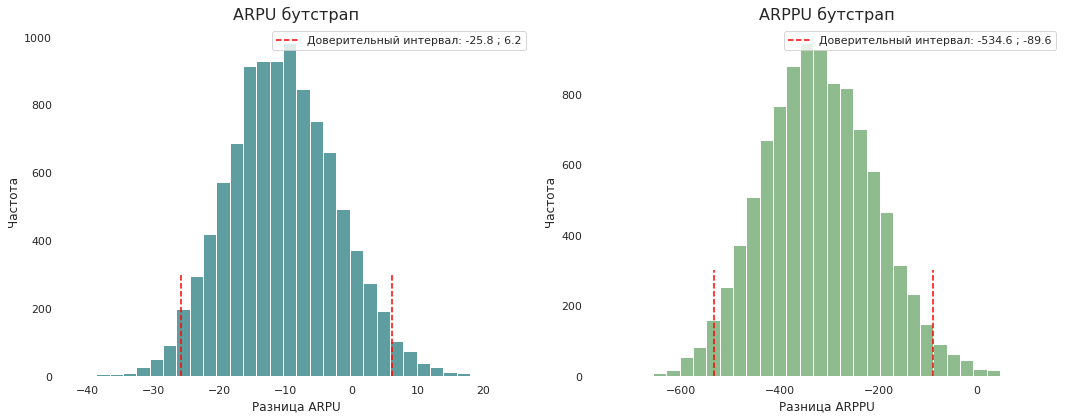

In [67]:
# Визуализируем результаты
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.hist(x=mean_diff_ARPU,
         bins=32,
         color='cadetblue')
plt.vlines(x=[min_ARPU, max_ARPU],
           ymin=0,
           ymax=300,
           linestyle='--',
           colors='red',
           label=f'Доверительный интервал: {min_ARPU} ; {max_ARPU}')
plt.title('ARPU бутстрап', size=16)
plt.xlabel('Разница ARPU', size=12)
plt.ylabel('Частота', size=12)
plt.legend(loc=0)

plt.subplot(1, 2, 2)
plt.hist(x=mean_diff_ARPPU,
         bins=32,
         color='darkseagreen')
plt.vlines(x=[min_ARPPU, max_ARPPU],
           ymin=0,
           ymax=300,
           linestyle='--',
           colors='red',
           label=f'Доверительный интервал: {min_ARPPU} ; {max_ARPPU}')
plt.title('ARPPU бутстрап', size=16)
plt.xlabel('Разница ARPPU', size=12)
plt.ylabel('Частота', size=12)
plt.legend(loc=0)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Доверительный интервал для разницы ARPU включает 0 -> **принимаем нулевую гипотезу об отсутствии различий в ARPU в контрольной и целевой группах**.

Доверительный интервал для разницы ARPPU не включает 0 -> **отвергаем нулевую гипотезу об отсутствии различий в ARPPU в контрольной и целевой группах**.

### Выводы

Для оценки эффективности внедрения новой механики оплаты услуг на сайте образовательной платформы проведен A/B-тест. Данные для проведения тестирования включали информацию о принадлежности 74484 пользователей сайта к контрольной (14671, 19.7%) и тестовой (59813, 80.3%) группам, об активности этих пользователей и о сумме совершенных ими платежей на сайте в дни проведения эксперимента. Результаты теста оценивались на пользователях, которые зашли на платформу в дни проведения эксперимента: 8328 студентов, из которых 1535 (18.4%) принадлежат контрольной группе и 6793 (81.6%) - целевой. Для получения достоверных выводов по результатам экспериментов в дальнейшем необходимо пересмотреть систему сплитования, чтобы размер выборок был сопоставимым.

Выбраны 3 наиболее чувствительные к результатам эксперимента метрики: *конверсия в оплату (CR)*, *средний доход на пользователя (ARPU)* и *средний доход на платящего пользователя (ARPPU)*. Проверялась следующая гипотеза: *Если внедрим новую механику оплаты, то пользователи сайта образовательной платформы перестанут стопориться на оплате услуг, вследствие чего CR, ARPU и ARPPU статистически значимо увеличатся*.

Для проверки гипотезы относительно *CR* использовался критерий Хи-квадрат. Конверсия в оплату для контрольной группы cоставила 5.1%, а для целевой группы - 4.6%. *Тест не выявил значимых различий между CR в контрольной и целевой группах*.

Метрики *ARPU* (для контрольной группы - 47.44 руб., для целевой - 57.86 руб.) и *ARPPU* (для контрольной группы - 933.59 руб., для целевой - 1255.83 руб.) оказались выше в тестовой группе. Данные о платежах по выборкам не соответствовали условиям проведения t-теста Стьюдента: распределения отличались от нормального, присутствовали аномально высокие значения. Метод бутстрапа показал *значимые различия ARPPU* и *незначимые различия ARPU* в контрольной и тестовой группах.

Результаты проведенного эксперимента неоднозначны. A/B-тестирование не выявило значимых различий в CR и ARPU для контрольной и целевой групп, но **ARPPU оказался значимо выше в тестовой группе (на 34,5%)**. Напрашивается вывод о том, что новая механика оплаты услуг действительно упрощает и ускоряет процесс оплаты (особенно для тех, кто ранее уже совершал платежи). Эффект от внедрения новой механики оплаты, оцененный по метрике ARPPU, оказался достаточно сильным для принятия решения в пользу **запуска нововведений на всех пользователей**. Однако следует учесть, что изначально пользователи по группам распределены неравномерно, а это может сказаться на точности выводов. Также *необходимо разобраться в причинах появления в данных 149 пользователей, которые совершали платежи в дни проведения эксперимента, но не учитывались как активные*.

### Задание 2. SQL
#### 2.1 Очень усердные ученики
Задание звучит следующим образом:

*Условие*. Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.\
*Задание*. Дана таблица **peas**:

|Название атрибута	|Тип атрибута	|Смысловое значение                      |
|-------------------|---------------|----------------------------------------|
|st_id	            |int	        |ID ученика                              |
|timest	            |timestamp	    |Время решения карточки                  |
|correct        	|bool	        |Правильно ли решена горошина?           |
|subject	        |text	        |Дисциплина, в которой находится горошина|

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.\
NB! Под *усердным* студентом мы понимаем студента, который **правильно решил 20 задач за текущий месяц**.

**Решение:**

Таблица *peas* содержит данные только за два дня - 30 и 31 октября 2021 года (это дни проведения эксперимента, описанного в задании 2.2, по внедрению нового экрана оплаты). С учетом имеющихся данных посчитать фактическое количество усердных студентов возможно только за октябрь 2021 года. Однако мы можем написать запрос, который считал бы усердных студентов именно за *текущий* месяц с помощью CURRENT_DATE.
Напишем два варианта запроса:
- количество усердных студентов за октябрь 2021 года
- количество усердных студентов за текущий месяц

*Первый вариант решения*

В первом случае мы не будем работать с датами, т.к. наши данные и так охватывают только октябрь 2021 года.
Этот запрос выведет id **136 усердных студентов** в порядке убывания количества правильно решенных задач.
```
SELECT
  st_id,
  SUM(correct :: integer) AS successfully_completed_peas
FROM
  peas
GROUP BY
  st_id
HAVING
  SUM(correct :: integer) >= 20
ORDER BY
  successfully_completed_peas DESC;
```
Этот запрос даст информацию о **количестве усердных студентов**, что и требовалось в задаче. Здесь используется подзапрос в FROM.
```
SELECT
  COUNT(st_id) AS number_of_diligent_students
FROM
  (
    SELECT
      st_id,
      SUM(correct :: integer)
    FROM
      peas
    GROUP BY
      st_id
    HAVING
      SUM(correct :: integer) >= 20
  ) AS diligent_students;
```

*Второй вариант решения*

Здесь всё то же самое, только в подзапрос добавляем условие **WHERE**, проверяющее **соответствие даты в таблице peas текущему месяцу**.
```
SELECT
  COUNT(st_id) AS number_of_diligent_students
FROM
  (
    SELECT
      st_id,
      SUM(correct :: integer)
    FROM
      peas
    WHERE
      to_char(timest, 'MM/YYYY') = to_char(CURRENT_DATE, 'MM/YYYY')
    GROUP BY
      st_id
    HAVING
      SUM(correct :: integer) >= 20
  ) AS diligent_students;
```

#### 2.2 Оптимизация воронки

Задание звучит следующим образом:

*Условие*. Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

*Задание*. Даны таблицы **peas** (в задании 2.1), **studs** и **final_project_check**. \
Таблица **studs**:

|Название атрибута	|Тип атрибута	|Смысловое значение                   |
|-------------------|---------------|-------------------------------------|
|st_id	            |int	        |ID ученика                           |
|test_grp           |text           |Метка ученика в данном эксперименте  |

Таблица **final_project_check**:

|Название атрибута	|Тип атрибута	|Смысловое значение                     |
|-------------------|---------------|---------------------------------------|
|st_id	            |int	        |ID ученика                             |
|sale_time          |timestamp      |Время покупки                          |
|money	            |int	        |Цена, по которой приобрели данный курс |
|subject	        |text 	        |Дисциплина                             |


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.\
**Активным** считается пользователь, *за все время решивший **больше 10** задач правильно в любых дисциплинах*.\
**Активным по математике** считается пользователь, *за все время решивший **2 или больше** задач правильно по математике*.

**Решение:**

Таблица **peas** содержится информация о **308** уникальных пользователях, которые решали горошины в дни проведения эксперимента (30 и 31 октября 2021 года).\
Таблица **studs** содержит информацию о принадлежности **600** уникальных пользователей к контрольной (test_grp = 'control') и тестовой (test_grp = 'pilot') группам. Студенты распределились по группам следующим образом: 305 студентов в контрольной и 295 - в тестовой группах.\
Таблица **final_project_check** содержит информацию о **47** уникальных пользователях, которые совершали покупки курсов в дни проведения эксперимента (30 и 31 октября 2021 года).

Между таблицами peas и final_project_check реализована связь "многие ко многим", что при их объединении будет вызывать дублирование данных. Чтобы собрать итоговую таблицу для расчета метрик, включающую всю необходимую информацию, необходимо предварительно сгруппировать данные по пользователям.
Отметим, что в таблице peas нет данных по двум студентам, которые есть в final_project_check. Эти студенты оплачивали курсы, но не проходили уроки в дни проведения эксперимента.

Для начала преобразуем таблицу peas - сгруппируем данные по студентам и посчитаем количество *правильно* решенных задач по всем дисциплинам и отдельно по математике (данные для идентификации студентов как активных и активных по математике). Затем присвоим студентам маркеры активности (булевая переменная) по всем дисциплинам (active_stud) и по математике (active_stud_math).
```
SELECT
  st_id,
  CASE
    WHEN SUM(all_correct) > 10 THEN 1
    ELSE 0
  END AS active_stud,
  CASE
    WHEN SUM(math_correct) >= 2 THEN 1
    ELSE 0
  END AS active_stud_math
FROM
  (
    SELECT
      st_id,
      SUM(correct :: int) AS all_correct,
      CASE
        WHEN subject = 'Math' THEN sum(correct :: int)
        ELSE 0
      END AS math_correct
    FROM
      peas
    GROUP BY
      st_id,
      subject
  ) AS p
GROUP BY
  st_id;
```

Этот запрос уже получается длинным, поэтому используем CTE (cte_p) для улучшения читаемости.

Теперь необходимо сгруппировать таблицу final_project_check по студентам, просуммировать их платежи по всем дисциплинам и отдельно по математике. Затем объединим таблицу studs с модифицированной таблицей final_project_check с помощью LEFT JOIN (нужно оставить информацию по всем пользователям, попавшим в группы).
```
SELECT
  s.st_id,
  s.test_grp,
  f.all_money,
  f.math_money
FROM
  studs s
  LEFT JOIN (
    SELECT
      st_id,
      SUM(all_money) :: int AS all_money,
      SUM(math_money) :: int AS math_money
    FROM
      (
        SELECT
          st_id,
          SUM(money) AS all_money,
          CASE
            WHEN subject = 'Math' THEN SUM(money)
            ELSE null
          END AS math_money
        FROM
          final_project_check
        GROUP BY
          st_id,
          subject
      ) AS f_money
    GROUP BY
      st_id
  ) f ON s.st_id = f.st_id;
```

Объединяем все столбцы в единую таблицу (cte_sfp).
```
WITH cte_p AS (
  SELECT
    st_id,
    CASE
      WHEN SUM(all_correct) > 10 THEN 1
      ELSE 0
    END AS active_stud,
    CASE
      WHEN SUM(math_correct) >= 2 THEN 1
      ELSE 0
    END AS active_stud_math
  FROM
    (
      SELECT
        st_id,
        SUM(correct :: int) AS all_correct,
        CASE
          WHEN subject = 'Math' THEN sum(correct :: int)
          ELSE 0
        END AS math_correct
      FROM
        peas
      GROUP BY
        st_id,
        subject
    ) AS p
  GROUP BY
    st_id
),
cte_sfp AS (
  SELECT
    s.st_id,
    s.test_grp,
    f.all_money,
    f.math_money,
    p.active_stud,
    p.active_stud_math
  FROM
    studs s
    LEFT JOIN (
      SELECT
        st_id,
        SUM(all_money) :: int AS all_money,
        SUM(math_money) :: int AS math_money
      FROM
        (
          SELECT
            st_id,
            SUM(money) AS all_money,
            CASE
              WHEN subject = 'Math' THEN SUM(money)
              ELSE null
            END AS math_money
          FROM
            final_project_check
          GROUP BY
            st_id,
            subject
        ) AS f_money
      GROUP BY
        st_id
    ) f ON s.st_id = f.st_id
    LEFT JOIN cte_p p ON s.st_id = p.st_id
)

SELECT *
FROM cte_sfp;
```

Теперь для выгрузки метрик можем работать с таблицей cte_sfp. Рассчитываем метрики с помощью вспомогательной таблицы (подзапрос в FROM). Затем группируем по test_grp.

**ИТОГОВЫЙ ЗАПРОС**
```
WITH cte_p AS (
  SELECT
    st_id,
    CASE
      WHEN SUM(all_correct) > 10 THEN 1
      ELSE 0
    END AS active_stud,
    CASE
      WHEN SUM(math_correct) >= 2 THEN 1
      ELSE 0
    END AS active_stud_math
  FROM
    (
      SELECT
        st_id,
        SUM(correct :: int) AS all_correct,
        CASE
          WHEN subject = 'Math' THEN sum(correct :: int)
          ELSE 0
        END AS math_correct
      FROM
        peas
      GROUP BY
        st_id,
        subject
    ) AS p
  GROUP BY
    st_id
),
cte_sfp AS (
  SELECT
    s.st_id,
    s.test_grp,
    f.all_money,
    f.math_money,
    p.active_stud,
    p.active_stud_math
  FROM
    studs s
    LEFT JOIN (
      SELECT
        st_id,
        SUM(all_money) :: int AS all_money,
        SUM(math_money) :: int AS math_money
      FROM
        (
          SELECT
            st_id,
            SUM(money) AS all_money,
            CASE
              WHEN subject = 'Math' THEN SUM(money)
              ELSE null
            END AS math_money
          FROM
            final_project_check
          GROUP BY
            st_id,
            subject
        ) AS f_money
      GROUP BY
        st_id
    ) f ON s.st_id = f.st_id
    LEFT JOIN cte_p p ON s.st_id = p.st_id
)
SELECT
  test_grp,
  SUM(revenue) / SUM(group_size) AS arpu,
  SUM(revenue_active_studs) / SUM(active_studs) AS arpau,
  SUM(paying_studs) / SUM(group_size) * 100 AS CR,
  SUM(active_paying) / SUM(active_studs) * 100 AS CR_active,
  SUM(math_active_paying) / SUM(math_active_studs) * 100 AS CR_math_active
FROM
  (
    SELECT
      test_grp,
      COUNT(st_id) AS group_size,
      SUM(all_money) AS revenue,
      SUM(active_stud) AS active_studs,
      CASE
        WHEN active_stud = 1 THEN SUM(all_money)
        ELSE NULL
      END AS revenue_active_studs,
      COUNT(all_money) AS paying_studs,
      CASE
        WHEN active_stud = 1
        AND all_money IS NOT NULL THEN SUM(active_stud)
        ELSE NULL
      END AS active_paying,
      SUM(active_stud_math) AS math_active_studs,
      CASE
        WHEN active_stud_math = 1
        AND math_money IS NOT NULL THEN SUM(active_stud_math)
        ELSE NULL
      END AS math_active_paying
    FROM
      cte_sfp
    GROUP BY
      test_grp,
      active_stud,
      all_money,
      active_stud_math,
      math_money
  ) AS auxiliary_table
GROUP BY
  test_grp
ORDER BY
  test_grp;
```

### Задание 3. Python

Необходимо реализовать:
- функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики;
- функцию, которая будет строить графики по получаемым метрикам.

In [68]:
# Считаем данные "с нуля"
groups = pd.read_csv('groups.csv', sep=';')
group_add = pd.read_csv('group_add.csv')
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';')

Напишем функцию, которая пересчитает метрики и занесет их в единую таблицу.

In [69]:
# Функция add_data на вход принимает файлы, которые мы считали
def add_data(groups_df, group_add_df, active_studs_df, checks_df):

    '''
    Переименуем заголовки в groups_df и group_add_df, 
    чтобы они были одинаковыми и связывались с active_studs_df и checks_df по student_id
    '''
    groups_df = groups_df.rename(columns={groups_df.columns[0]: 'student_id', groups_df.columns[1]: 'grp'})
    group_add_df = group_add_df.rename(columns={group_add_df.columns[0]: 'student_id',
                                                group_add_df.columns[1]: 'grp'})

    # Добавим в groups_df новые строки из group_add_df
    groups_df = pd.concat([groups_df, group_add_df], ignore_index=True)

    # Объединим датафреймы groups_df и active_studs_df
    final_groups_active = groups_df.merge(active_studs_df, on='student_id', how='inner')

    # Объединим датафреймы final_groups_active и checks_df для получения информации о платежах
    final_control_test = final_groups_active.merge(checks_df, on='student_id', how='left')

    # Посчитаем метрики CR, ARPU и ARPPU
    # Для удобства создаем отдельные датафреймы для контрольной и целевой групп
    final_control_test_a = final_control_test[final_control_test['grp'] == 'A']
    final_control_test_b = final_control_test[final_control_test['grp'] == 'B']

    '''
    Считаем по группам: 
    - количество участвовавших в эксперименте пользователей всего
    - количество платящих пользователей 
    - сумму платежей
    Заносим результаты вычислений в словарь metrics_dict
    '''
    metrics_dict = {
        'A': {
            'num_of_users': int(final_control_test_a.shape[0]),
            'num_of_paying_users': int(final_control_test_a.rev.count()),
            'revenue': int(final_control_test_a.rev.sum())
        },
        'B': {
            'num_of_users': int(final_control_test_b.shape[0]),
            'num_of_paying_users': int(final_control_test_b.rev.count()),
            'revenue': int(final_control_test_b.rev.sum())
        }
    }

    # Собираем полученные показатели в единый датафрейм из словаря
    local_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')

    # Считаем CR, ARPU, ARPPU, добавляем столбцы с метриками в local_metrics
    local_metrics['Конверсия в оплату (CR), %'] = \
        round((local_metrics.num_of_paying_users / local_metrics.num_of_users * 100), 1)
    local_metrics['Средний доход на пользователя (ARPU), руб.'] = \
        round((local_metrics.revenue / local_metrics.num_of_users), 2)
    local_metrics['Средний доход на платящего пользователя (ARPPU), руб.'] = \
        round((local_metrics.revenue / local_metrics.num_of_paying_users), 2)

    # Изменим названия столбцов
    local_metrics = local_metrics.rename(columns={'num_of_users': 'Кол-во пользователей, чел.',
                                                  'num_of_paying_users': 'Кол-во платящих пользователей, чел.',
                                                  'revenue': 'Сумма платежей, руб.'})

    return local_metrics

In [70]:
# Проверим вывод функции
metrics_df = add_data(groups, group_add, active_studs, checks)
metrics_df

,"Кол-во пользователей, чел.","Кол-во платящих пользователей, чел.","Сумма платежей, руб.","Конверсия в оплату (CR), %","Средний доход на пользователя (ARPU), руб.","Средний доход на платящего пользователя (ARPPU), руб."
A,1538,78,72820,5.1,47.35,933.59
B,6803,314,394974,4.6,58.06,1257.88


In [71]:
# Раскрасим максимальные значения по столбцам с метриками
add_data(groups, group_add, active_studs, checks) \
    .style \
    .format('{:.1f}', subset=['Конверсия в оплату (CR), %']) \
    .format('{:.2f}', subset=['Средний доход на пользователя (ARPU), руб.',
                              'Средний доход на платящего пользователя (ARPPU), руб.']) \
    .highlight_max(color='darkseagreen', subset=['Конверсия в оплату (CR), %',
                                                 'Средний доход на пользователя (ARPU), руб.',
                                                 'Средний доход на платящего пользователя (ARPPU), руб.'])

,"Кол-во пользователей, чел.","Кол-во платящих пользователей, чел.","Сумма платежей, руб.","Конверсия в оплату (CR), %","Средний доход на пользователя (ARPU), руб.","Средний доход на платящего пользователя (ARPPU), руб."
A,1538,78,72820,5.1,47.35,933.59
B,6803,314,394974,4.6,58.06,1257.88


Напишем функцию, которая визуализирует наши метрики.

In [72]:
# Функция show_diagram на вход принимает таблицу с метриками
def show_diagram(metrics_table):
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))

    sns.barplot(data=metrics_table,
                x=metrics_table.index,
                y='Конверсия в оплату (CR), %',
                ax=axes[0],
                palette=['lightcoral', 'powderblue'])
    axes[0].set_ylim(0, 50)
    axes[0].set_title('CR', size=14, color='black', fontweight='bold')
    axes[0].set_xlabel('Группы', color='black', size=12)
    axes[0].set_ylabel('Конверсия в оплату, %', color='black', size=12)
    axes[0].tick_params(axis='x', colors='black')
    axes[0].tick_params(axis='y', colors='black')
    axes[0].text(x=-0.1, y=metrics_table.loc['A', 'Конверсия в оплату (CR), %'],
                 s=metrics_table.loc['A', 'Конверсия в оплату (CR), %'],
                 size=12, color='black')
    axes[0].text(x=0.9, y=metrics_table.loc['B', 'Конверсия в оплату (CR), %'],
                 s=metrics_table.loc['B', 'Конверсия в оплату (CR), %'],
                 size=12, color='black')

    sns.barplot(data=metrics_table,
                x=metrics_table.index,
                y='Средний доход на пользователя (ARPU), руб.',
                ax=axes[1],
                palette=['lightcoral', 'powderblue'])
    axes[1].set_title('ARPU', size=14, color='black', fontweight='bold')
    axes[1].set_xlabel('Группы', color='black', size=12)
    axes[1].set_ylabel('Средний доход на пользователя, руб.', color='black', size=12)
    axes[1].tick_params(axis='x', colors='black')
    axes[1].tick_params(axis='y', colors='black')
    axes[1].text(x=-0.1, y=metrics_table.loc['A', 'Средний доход на пользователя (ARPU), руб.'],
                 s=metrics_table.loc['A', 'Средний доход на пользователя (ARPU), руб.'],
                 size=12, color='black')
    axes[1].text(x=0.9, y=metrics_table.loc['B', 'Средний доход на пользователя (ARPU), руб.'],
                 s=metrics_table.loc['B', 'Средний доход на пользователя (ARPU), руб.'],
                 size=12, color='black')

    sns.barplot(data=metrics_table,
                x=metrics_table.index,
                y='Средний доход на платящего пользователя (ARPPU), руб.',
                ax=axes[2],
                palette=['lightcoral', 'powderblue'])
    axes[2].set_title('ARPPU', size=14, color='black', fontweight='bold')
    axes[2].set_xlabel('Группы', color='black', size=12)
    axes[2].set_ylabel('Средний доход на платящего пользователя, руб.', color='black', size=12)
    axes[2].tick_params(axis='x', colors='black')
    axes[2].tick_params(axis='y', colors='black')
    axes[2].text(x=-0.15, y=metrics_table.loc['A', 'Средний доход на платящего пользователя (ARPPU), руб.'],
                 s=metrics_table.loc['A', 'Средний доход на платящего пользователя (ARPPU), руб.'],
                 size=12, color='black')
    axes[2].text(x=0.8, y=metrics_table.loc['B', 'Средний доход на платящего пользователя (ARPPU), руб.'],
                 s=metrics_table.loc['B', 'Средний доход на платящего пользователя (ARPPU), руб.'],
                 size=12, color='black')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

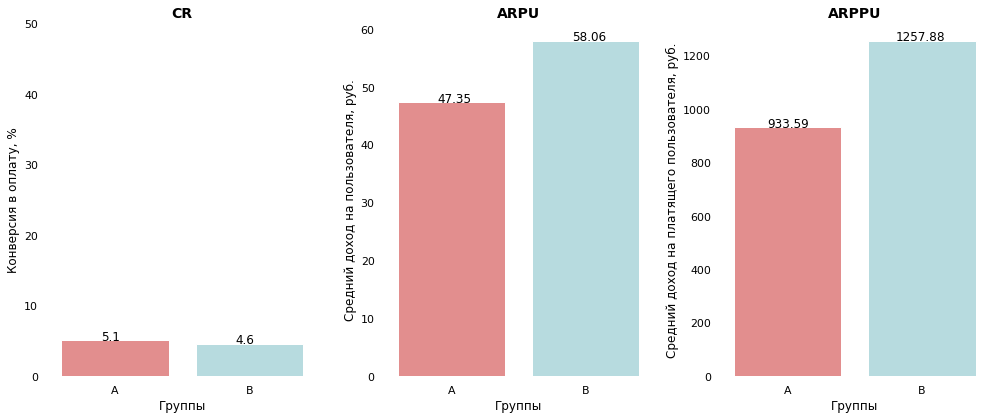

In [73]:
# Проверим вывод функции
show_diagram(metrics_df)